/tmp/ipykernel_15884/3091926584.py:47: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  inc_mtx = nx.incidence_matrix(graph)


   nodes  source  pressure
0      0     5.0  0.990512
1      1     0.0 -0.200388
2      2     0.0  0.433611
3      3     0.0 -0.152179
4      4     0.0 -0.255669
5      5     0.0 -0.365414
6      6     0.0  0.383744
7      7     0.0  0.239437
8      8    -5.0 -2.907894
    ed-  -ges    length  conduct.      flow  press_diff
0     0     2  0.999877  1.000487  1.424620    1.423751
1     0     3  0.999367  0.999845  0.838866    0.838465
2     0     4  0.999412  1.000649  0.735477    0.734568
3     0     5  0.999742  1.000936  0.625519    0.624773
4     0     6  0.999502  0.999809  1.375519    1.375097
5     1     2  0.999125  0.999658  0.233057    0.232933
6     1     4  1.000574  1.000009 -0.456086   -0.456344
7     1     6  1.000145  1.000678  0.183956    0.183858
8     1     7  1.000813  0.999520  0.039073    0.039124
9     2     6  0.999464  1.000960  0.817773    0.816552
10    2     8  0.999305  1.000370 -2.475450   -2.472815
11    3     4  0.999268  0.999695 -0.408022   -0.407848
12

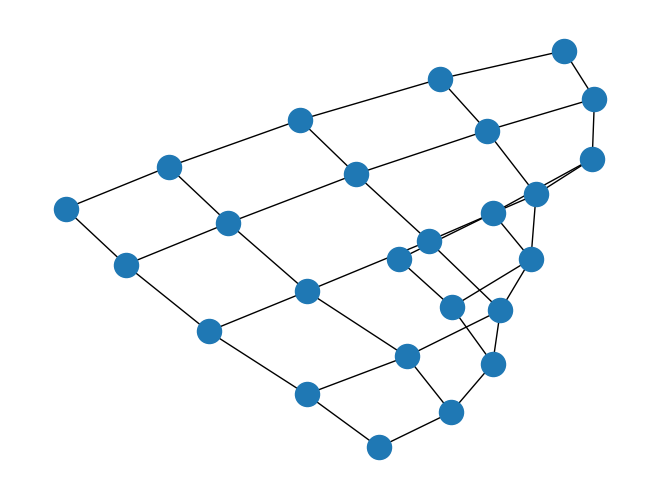

time elapsed: 0.39s


In [1]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy

"""
General idea:
adjacency matrix --> incidence matrix, nodes, edges --> 
---> assign physical attributes --> run simulation --> create visualisation
"""


# undirected graph
def generate_random_adjacent_matrix(dimension):   # dimension == #nodes
    condition = True
    while condition:
        matrix = np.zeros((dimension, dimension))
        for i in range(dimension):
            for j in range(dimension):
                if i != j:
                    matrix[i][j] = random.choice([0, 1])
        L = np.tril(matrix)
        U = np.transpose(L)                    # np.sum(U) == #edges
        symmetric_matrix = L + U
        if np.sum(symmetric_matrix) != 0:
            if np.trace(symmetric_matrix) == 0:
                if np.linalg.det(symmetric_matrix) != 0:
                    return symmetric_matrix
                    condition = False        # finish the process and create required matrix
                else:
                    pass
                    #print("Error: some of the nodes are not connected.")
            else:
                pass
                #print("Error: generated matrix isn't an adjacent one as its trace is nonzero.")
        else:
            pass
            #print("Error: generated matrix has zero-valued elements only and thus can't represent a graph.")



def generate_graph(adjacent_matrix):
    graph = nx.from_numpy_matrix(adjacent_matrix, parallel_edges=True)
    inc_mtx = nx.incidence_matrix(graph)
    inc_mtx_dense = scipy.sparse.csr_matrix.todense(inc_mtx)
    inc_mtx_dense_int = inc_mtx_dense.astype(int)
    nodes_list = graph.nodes()
    edges_list = graph.edges()
    nodes_data = pd.DataFrame(nodes_list)
    edges_data = pd.DataFrame(edges_list)
    return inc_mtx_dense_int, graph, nodes_data, edges_data


def generate_physical_values(dimension, source_value, incidence_matrix):
    edges_dim = np.shape(incidence_matrix)[1]
    incidence_T = incidence_matrix.transpose()
    incidence_T_inv = np.linalg.pinv(incidence_T)
    incidence_inv = np.linalg.pinv(incidence_matrix)
    conductivity_list = np.ones(edges_dim) + np.random.default_rng().uniform(-0.001, 0.001, edges_dim)  # ones + stochastic noise
    length_list = np.ones(edges_dim) + np.random.default_rng().uniform(-0.001, 0.001, edges_dim)        # vector from edges space
    source_list = np.zeros(dimension)             # vector from nodes space
    source_list[0] = source_value                 # but I want the central node to be the source, how to fix this?
    source_list[dimension-1] = -source_value      # but I want only outermost nodes to be the sinks, how to do this?
    # q = S * (delta^T)^-1
    flow_list = np.dot(source_list, incidence_T_inv)
    # delta*p = K/L * q
    pressure_diff_list = length_list * (1/conductivity_list) * flow_list
    pressure_list = np.dot(pressure_diff_list, incidence_inv)
    # x = delta^T * K/L *delta
    x = incidence_matrix  @ np.diag(1/length_list) @ np.diag(conductivity_list)  @ incidence_T
    x_dagger = np.linalg.pinv(x)  # Penrose pseudo-inverse
    # update data frames for both spaces
    nodes_data.insert(loc=1, column='source', value=source_list)
    nodes_data.columns = ['nodes', 'source']
    nodes_data.insert(loc=2, column='pressure', value=pressure_list)
    print(nodes_data)
    edges_data.columns = ['ed-', '-ges']
    edges_data['length'] = length_list
    edges_data['conduct.'] = conductivity_list
    edges_data['flow'] = flow_list
    edges_data['press_diff'] = pressure_diff_list
    print(edges_data)
    return x_dagger, incidence_T, incidence_inv, source_list, pressure_list, length_list, conductivity_list, flow_list


def run_simulation(flow_list, conductivity_list, a, b, gamma, delta, flow_hat, c, r, dt, N):
    # solving diff eq
    t = 0
    for n in range(1, N+1):
        if not any(k < 0 for k in conductivity_list):  # in the future I'll just delete the edges with K == 0 -- their radius is zero
            t = dt * n
            # dK/dt = a*(exp(r*t/2)^(delta) * q / q_hat)^(2*gamma) - b * K + c
            # flow_list is separated into its sign and value, because I don't want to get complex values
            # the direction of the flow is maintained while its value changes
            # the information about direction is not coded into graph, so I have to be careful here
            dK = dt * (np.sign(flow_list) * np.float_power(a * (np.exp(r*t*delta/2) * np.abs(flow_list) / flow_hat), (2 * gamma)) - b * conductivity_list + c)
            conductivity_list += dK

            x = incidence_matrix @ np.diag(1 / length_list) @ np.diag(conductivity_list) @ incidence_T
            x_dagger = np.linalg.pinv(x)
            # q = K/L * delta * (delta^T * K/L * delta)^dagger * S
            flow_list = source_list @ (x_dagger @ incidence_matrix) @ np.diag(conductivity_list) @ np.diag(1 / length_list)
            pressure_diff_list = length_list * (1 / conductivity_list) * flow_list
            pressure_list = np.dot(pressure_diff_list, incidence_inv)
    print('simulation time: ', t, ' seconds')

    # updating data frames
    edges_data['conduct.'] = conductivity_list
    edges_data['flow'] = flow_list
    edges_data['press_diff'] = pressure_diff_list
    print(edges_data)
    nodes_data['pressure'] = pressure_list
    print(nodes_data)


def draw_graph(graph):
    nx.draw(graph)
    plt.savefig("graph.png")
    # show nodes number
    # nodes colour - heatmap of pressure
    # edges length - proportional to length
    # edges thickness - proportional to (conductivity)^(-4)


if __name__ == '__main__':
    start_time = time.time()

    number_of_nodes = 9
    adjacency_matrix = generate_random_adjacent_matrix(number_of_nodes)
    incidence_matrix, graph, nodes_data, edges_data = generate_graph(adjacency_matrix)
    source_value = 5
    x_dagger, incidence_inv, incidence_T, source_list, pressure_list, length_list, conductivity_list, flow_list = generate_physical_values(number_of_nodes, source_value, incidence_matrix)
    #draw_graph(graph)
    parameters_set = {'a': 1.7, 'b': 0.5, 'gamma': 2/3, 'delta': 2.1, 'flow_hat': 3.4, 'c': 0.9, 'r': 1, 'dt': 0.01, 'N': 100}
    run_simulation(flow_list, conductivity_list, **parameters_set)
    L = 5
    G = nx.grid_2d_graph(L, L)
    nx.draw(G)
    plt.show()

    print("time elapsed: {:.2f}s".format(time.time() - start_time))

In [2]:
pip install matplotlib

  Using cached matplotlib-3.6.2-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (9.4 MB)
  Using cached cycler-0.11.0-py3-none-any.whl (6.4 kB)
  Using cached contourpy-1.0.6-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (295 kB)
  Using cached fonttools-4.38.0-py3-none-any.whl (965 kB)
  Using cached kiwisolver-1.4.4-cp38-cp38-manylinux_2_5_x86_64.manylinux1_x86_64.whl (1.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
print("Hello")


Hello


In [3]:
pip install numpy


     |████████████████████████████████| 17.1 MB 19 kB/s  eta 0:00:01    |█▊                              | 942 kB 1.2 MB/s eta 0:00:14     |███████████████████▌            | 10.4 MB 3.4 MB/s eta 0:00:02
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install networkx

  Using cached networkx-2.8.8-py3-none-any.whl (2.0 MB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install pandas

     |████████████████████████████████| 12.2 MB 55 kB/s  eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install scipy

  Using cached scipy-1.9.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (33.8 MB)
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install random

ERROR: Could not find a version that satisfies the requirement random (from versions: none)
ERROR: No matching distribution found for random
Note: you may need to restart the kernel to use updated packages.


In [2]:
!jupyter --version


Selected Jupyter core packages...
IPython          : 8.6.0
ipykernel        : 6.17.1
ipywidgets       : 7.7.1
jupyter_client   : 7.4.7
jupyter_core     : 5.0.0
jupyter_server   : 1.23.3
jupyterlab       : 3.5.0
nbclient         : 0.7.0
nbconvert        : 7.2.5
nbformat         : 5.7.0
notebook         : 6.5.2
qtconsole        : not installed
traitlets        : 5.5.0


In [3]:
pip install --upgrade jupyterlab jupyterlab-git

Requirement already up-to-date: jupyterlab in ./.local/lib/python3.8/site-packages (3.5.0)
     |████████████████████████████████| 1.2 MB 14 kB/s  eta 0:00:01
     |████████████████████████████████| 5.3 MB 1.5 MB/s eta 0:00:01
     |████████████████████████████████| 182 kB 444 kB/s eta 0:00:01
     |████████████████████████████████| 3.1 MB 439 kB/s eta 0:00:01
     |████████████████████████████████| 62 kB 218 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
